In [1]:
import os

import dask.diagnostics
import fsspec
import numpy as np
import pandas as pd
import proplot
import vcm
import vcm.catalog
import vcm.fv3
import xarray as xr

import plotting
import xhistogram.xarray
from matplotlib.lines import Line2D

In [2]:
plotting.configure_style(fontsize=8, legend_fontsize=8)

In [3]:
def open_tape(root, tape):
    path = os.path.join(root, f"{tape}.zarr")
    mapper = fsspec.get_mapper(path)
    return vcm.fv3.standardize_fv3_diagnostics(xr.open_zarr(mapper))


def open_cases(roots, tape):
    datasets = []
    for climate, root in roots.items():
        ds = open_tape(root, tape).assign_coords(climate=climate)
        datasets.append(ds)
    return xr.concat(datasets, dim="climate")

In [4]:
BASELINE = {
    "Minus 4 K": "gs://vcm-ml-experiments/spencerc/2022-01-22/n2f-25km-baseline-minus-4k-snoalb/fv3gfs_run",
    "Unperturbed": "gs://vcm-ml-experiments/spencerc/2022-01-22/n2f-25km-baseline-unperturbed-snoalb/fv3gfs_run",
    "Plus 4 K": "gs://vcm-ml-experiments/spencerc/2022-01-22/n2f-25km-baseline-plus-4k-snoalb/fv3gfs_run",
    "Plus 8 K": "gs://vcm-ml-experiments/spencerc/2022-07-01/n2f-25km-baseline-updated-plus-8k-snoalb/fv3gfs_run",
}

In [5]:
ML_CORRECTED = {
    "Minus 4 K": "gs://vcm-ml-experiments/spencerc/2022-06-30/n2f-25km-ml-corrected-updated-v3-minus-4k-seed-1/fv3gfs_run",
    "Unperturbed": "gs://vcm-ml-experiments/spencerc/2022-06-30/n2f-25km-ml-corrected-updated-v3-unperturbed-seed-1/fv3gfs_run",
    "Plus 4 K": "gs://vcm-ml-experiments/spencerc/2022-06-30/n2f-25km-ml-corrected-updated-v3-plus-4k-seed-1/fv3gfs_run",
    "Plus 8 K": "gs://vcm-ml-experiments/spencerc/2022-06-30/n2f-25km-ml-corrected-updated-v3-plus-8k-seed-1/fv3gfs_run",
}

In [6]:
FINE_RESOLUTION = {
    "Minus 4 K": "gs://vcm-ml-raw-flexible-retention/2021-01-04-1-year-C384-FV3GFS-simulations/minus-4K/C384-to-C48-diagnostics",
    "Unperturbed": "gs://vcm-ml-raw-flexible-retention/2021-01-04-1-year-C384-FV3GFS-simulations/unperturbed/C384-to-C48-diagnostics",
    "Plus 4 K": "gs://vcm-ml-raw-flexible-retention/2021-01-04-1-year-C384-FV3GFS-simulations/plus-4K/C384-to-C48-diagnostics",
    "Plus 8 K": "gs://vcm-ml-raw-flexible-retention/2022-06-02-two-year-C384-FV3GFS-simulations/plus-8K/C384-to-C48-diagnostics"
}

In [7]:
SECONDS_PER_DAY = 86400

baseline = SECONDS_PER_DAY * open_cases(BASELINE, "diags").sel(time=slice("2018-11", "2023-10")).total_precipitation_rate.resample(time="D").mean()
ml_corrected = SECONDS_PER_DAY * open_cases(ML_CORRECTED, "diags").sel(time=slice("2018-11", "2023-10")).total_precipitation_rate.resample(time="D").mean()
fine_resolution = SECONDS_PER_DAY * open_cases(FINE_RESOLUTION, "gfsphysics_15min_coarse").sel(time=slice("2018-08", "2019-07")).PRATEsfc.rename("total_precipitation_rate")
fine_resolution = fine_resolution.resample(time="D").mean()

In [8]:
BINS = np.logspace(-1, np.log10(1000), 201)

baseline_histogram = xhistogram.xarray.histogram(baseline, bins=BINS, dim=["x", "y", "tile", "time"], density=True)
ml_corrected_histogram = xhistogram.xarray.histogram(ml_corrected, bins=BINS, dim=["x", "y", "tile", "time"], density=True)
fine_resolution_histogram = xhistogram.xarray.histogram(fine_resolution, bins=BINS, dim=["x", "y", "tile", "time"], density=True)

In [9]:
histograms = xr.concat(
    [baseline_histogram, ml_corrected_histogram, fine_resolution_histogram],
    dim=pd.Index(["Baseline", "ML-corrected (seed 1)", "Fine resolution (year two)"], name="case")
)

In [10]:
with dask.diagnostics.ProgressBar():
    histograms = histograms.compute()

[########################################] | 100% Completed | 20min  4.2s


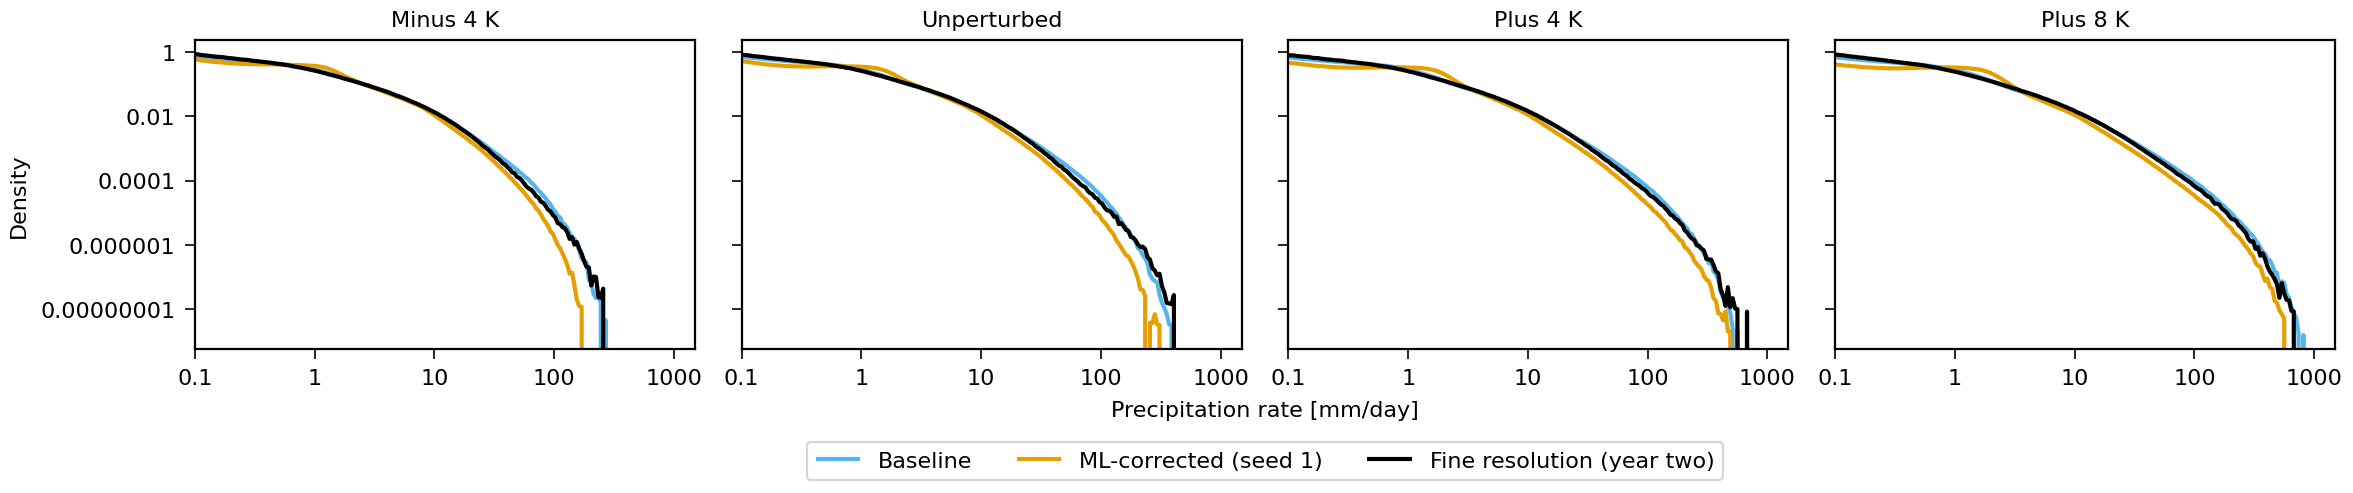

In [12]:
fig, axes = proplot.subplots(ncols=4, nrows=1, refaspect=1/0.618)
COLORS = {
    "Baseline": "#56B4E9",
    "ML-corrected (seed 1)": "#E69F00",
    "Fine resolution (year two)": "#000000"
}

for ax, climate in zip(axes, histograms.climate):
    for case, color in COLORS.items():
        histograms.sel(climate=climate, case=case).plot(
            ax=ax, color=color,
            add_legend=False,
            xscale="log",
            yscale="log"
        )
    ax.set_title(climate.item())
    ax.set_xlabel("Precipitation rate [mm/day]")
    ax.set_ylabel("Density")
    ax.set_xlim(0.1, 1500)

handles = []
for label, color in COLORS.items():
    h = Line2D([0], [0], label=label, color=color)
    handles.append(h)

fig.legend(handles, loc="b", ncol=3)

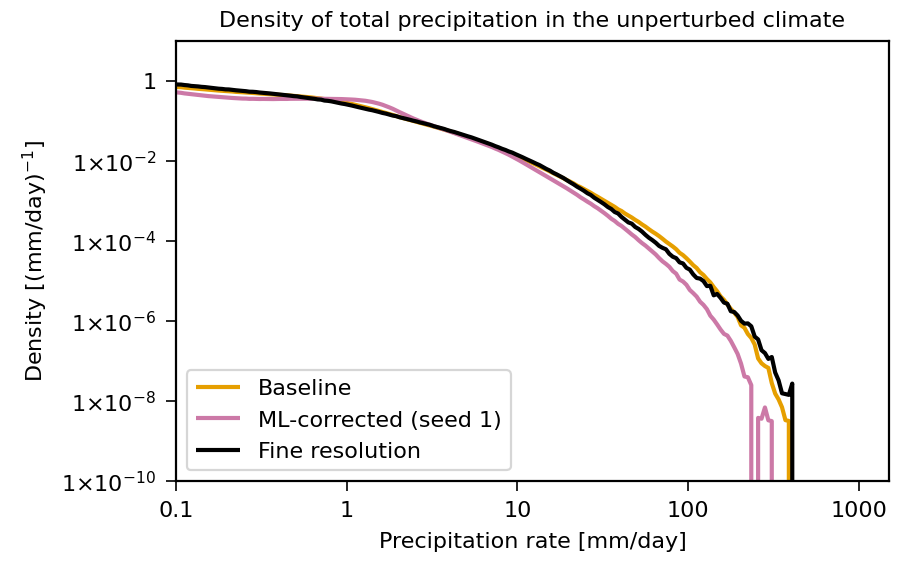

In [14]:
fig, ax = proplot.subplots(ncols=1, nrows=1, refaspect=1/0.618, sharey=False, figwidth=4.5)
COLORS = {
    "Baseline": "#E69F00",
    "ML-corrected (seed 1)": "#CC79A7",
    "Fine resolution (year two)": "#000000"
}

for case, color in COLORS.items():
    histograms.sel(case=case, climate="Unperturbed").plot(
        ax=ax, color=color,
        add_legend=False,
        xscale="log",
        yscale="log"
    )
ax.set_title("Density of total precipitation in the unperturbed climate")
ax.set_xlabel("Precipitation rate [mm/day]")
ax.set_ylabel("Density [(mm/day)$^{-1}$]")
ax.set_xlim(0.1, 1500)
ax.set_ylim(1e-10, 10)

handles = []
for label, color in COLORS.items():
    if "Fine resolution" in label:
        h = Line2D([0], [0], label="Fine resolution", color=color)
    else:
        h = Line2D([0], [0], label=label, color=color)
    handles.append(h)

ax.format(yformatter="sci")

ax.legend(handles, loc="lower left", ncol=1)
fig.savefig("figures/figure-S02.pdf", dpi=200)
fig.savefig("figures/figure-S02.png", dpi=200)

In [15]:
def insert_ml_precipitation(ds):
    ml_precipitation = ds.total_precipitation_rate - ds.physics_precip
    return ds.assign(ml_precipitation=ml_precipitation)

In [16]:
ml_corrected = insert_ml_precipitation(SECONDS_PER_DAY * open_cases(ML_CORRECTED, "diags")).sel(time=slice("2018-11", "2023-10"))

In [12]:
with dask.diagnostics.ProgressBar():
    mean_precip = ml_corrected[["ml_precipitation", "total_precipitation_rate"]].mean("time").compute()

[########################################] | 100% Completed |  9min 55.3s


In [13]:
grid = vcm.catalog.catalog["grid/c48"].to_dask()
global_mean = mean_precip.weighted(grid.area).mean(["x", "y", "tile"]).compute()

In [14]:
global_mean.ml_precipitation / global_mean.total_precipitation_rate

<xarray.DataArray (climate: 4)>
array([0.23624942, 0.2638779 , 0.27340339, 0.28711212])
Coordinates:
  * climate  (climate) <U11 'Minus 4 K' 'Unperturbed' 'Plus 4 K' 'Plus 8 K'

In [21]:
with dask.diagnostics.ProgressBar():
    ml_corrected_daily_mean_max = ml_corrected.ml_precipitation.sel(climate="Unperturbed").resample(time="D").mean().max(["x", "y", "tile", "time"]).compute()
    ml_corrected_daily_mean_min = ml_corrected.ml_precipitation.sel(climate="Unperturbed").resample(time="D").mean().min(["x", "y", "tile", "time"]).compute()

[########################################] | 100% Completed |  3min 14.0s
[########################################] | 100% Completed |  2min 57.2s


In [22]:
ml_corrected_daily_mean_max

<xarray.DataArray 'ml_precipitation' ()>
array(8.21252651)
Coordinates:
    climate  <U11 'Unperturbed'

In [23]:
ml_corrected_daily_mean_min

<xarray.DataArray 'ml_precipitation' ()>
array(-1.23349858)
Coordinates:
    climate  <U11 'Unperturbed'